In [97]:
### TODO: set your own directories
import os
from PIL import Image
import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import natsort
from PIL import Image
from torch.utils.data import DataLoader, Dataset

data_dir = '../../data/'
# preprocessed_dir = '../../data_preprocessed/'
result_dir = '../../results/'

print(os.getcwd())

C:\Users\kwyma\OneDrive - UW\MasterWork\_UW - Grad\Deep Learning\Landscape-Generation-GAN\src


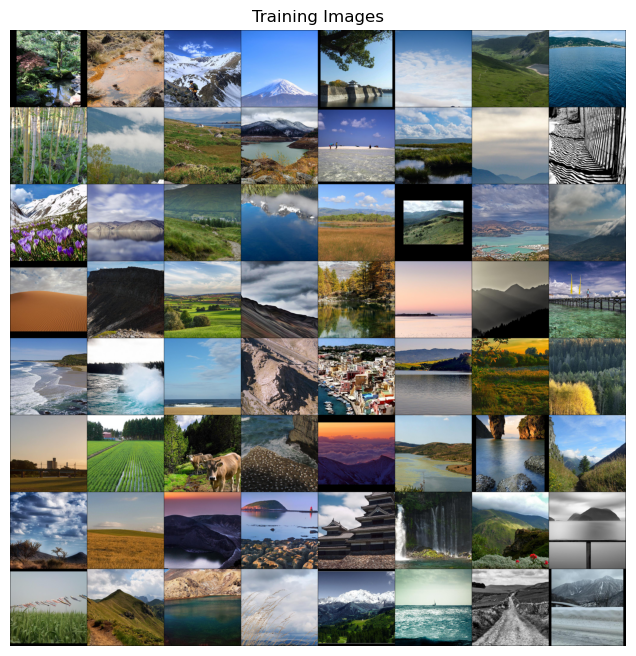

In [100]:
class LandscapeDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_images = os.listdir(main_dir)
        self.total_images = natsort.natsorted(all_images)

    def __len__(self):
        return len(self.total_images)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_images[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
image_size = 512
batch_size = 128

transform = transforms.Compose([
                                transforms.CenterCrop(image_size), # if saving preproc, disable
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                ])

# NOTE: if saving pre proc, use preprocessed_dir
landscape_data = LandscapeDataset(data_dir, transform=transform)
data_loader = DataLoader(dataset=landscape_data, batch_size=batch_size, shuffle=True)

# for testing
# data_loader = DataLoader(dataset=landscape_data, batch_size=4, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [ ]:
num_channels = 3
input_size = 512
output_size = 1
gen_filter = 256
dis_filter = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Generator of DC-GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(input_size, gen_filter * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(gen_filter * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter * 8, gen_filter * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_filter * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter * 4, gen_filter * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_filter * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter * 2, gen_filter, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_filter),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_filter, num_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


# Discriminator of DC-GAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, dis_filter, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter, dis_filter * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(dis_filter * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter * 2, dis_filter * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(dis_filter * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter * 4, dis_filter * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(dis_filter * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_filter * 8, output_size, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# custom weights initialization with mean=0, stdev=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(m.bias.data, 0)


generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)
print(generator)
print(discriminator)
